In [11]:
# -*- coding: utf-8 -*-
"""
Created on Fri Oct 18 00:34:05 2019

@author: USER
"""
import pandas as pd          
import numpy as np          # For mathematical calculations
import matplotlib.pyplot as plt  # For plotting graphs
from datetime import datetime    # To access datetime
from pandas import Series        # To work on series
import matplotlib
import warnings                   # To ignore the warnings
warnings.filterwarnings("ignore")
from math import sqrt
from sklearn.metrics import mean_squared_error
from numpy import array

#Reading Data
df = pd.read_excel('Merged_pollution_dataset - wo 2016 17.xlsx')
df_bbsr = df[(df['City/Town/Village/Area'] == 'Bhubaneswar') | (df['City/Town/Village/Area'] == 'Bhubaneshwar')]

df_bbsr.dtypes

df_bbsr['RSPM/PM10'] = pd.to_numeric(df_bbsr['RSPM/PM10'], errors='coerce')
df_bbsr['SO2'] = pd.to_numeric(df_bbsr['SO2'], errors='coerce')
df_bbsr['NO2'] = pd.to_numeric(df_bbsr['NO2'], errors='coerce')
df_bbsr['SPM'] = pd.to_numeric(df_bbsr['SPM'], errors='coerce')

df_bbsr.dtypes

#Data Preprocessing
df_bbsr['Location of Monitoring Station'].replace('SPCB Building, Bhubaneshwar', 'OSPCB Bldg',inplace=True)
df_bbsr['Location of Monitoring Station'].replace('Capital Police Station, Bhubaneshwar', 'Capital Police Stn.',inplace=True)
df_bbsr['Location of Monitoring Station'].replace('IRC Vilage, Bhubaneshwar', 'IRC',inplace=True)
df_bbsr['Location of Monitoring Station'].replace('Chandrasekharpur. Bhubneswar', 'Chandrasekharpur',inplace=True)
df_bbsr['Location of Monitoring Station'].replace('Water works, Palasuni, Bhubneswar', 'Palasuni',inplace=True)
df_bbsr['Location of Monitoring Station'].replace('Patrapada, Bhubneswar', 'Patrapada',inplace=True)

df_bbsr_cps = df_bbsr[(df_bbsr['Location of Monitoring Station'] == 'Capital Police Stn.')]

#Initial Analysis
#Checking the datatypes of various columns
df_bbsr_cps.dtypes

#Converting object to Datetime
df_bbsr_cps.reset_index(inplace = True)
df_bbsr_cps = df_bbsr_cps.drop(['index'], axis = 1)
df_bbsr_cps['Sampling Date'] = pd.to_datetime(df_bbsr_cps['Sampling Date'], format='%Y-%m-%d %H:%M')
df_bbsr_cps['Sampling Date'] = pd.to_datetime(df_bbsr_cps['Sampling Date'], format='%Y-%m-%d %H:%M')


df_bbsr_cps.dtypes

#Setting default Plot Size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,8

print("SUCCESS!!")
df_bbsr_cps.head()

SUCCESS!!


,Stn Code,Sampling Date,State,City/Town/Village/Area,Location of Monitoring Station,Agency,Type of Location,SO2,NO2,RSPM/PM10,SPM
0,NaN,2005-04-01,Orissa,Bhubaneshwar,Capital Police Stn.,Odisha State Pollution Control Board,Residential and others,NaN,21.0,172.0,261.0
1,NaN,2005-06-01,Orissa,Bhubaneshwar,Capital Police Stn.,Odisha State Pollution Control Board,Residential and others,NaN,20.0,126.0,192.0
2,NaN,2005-09-01,Orissa,Bhubaneshwar,Capital Police Stn.,Odisha State Pollution Control Board,Residential and others,NaN,16.0,132.0,220.0
3,NaN,2005-12-01,Orissa,Bhubaneshwar,Capital Police Stn.,Odisha State Pollution Control Board,Residential and others,NaN,25.0,125.0,217.0
4,NaN,2005-01-14,Orissa,Bhubaneshwar,Capital Police Stn.,Odisha State Pollution Control Board,Residential and others,NaN,14.0,140.0,219.0


SUCCESS!!


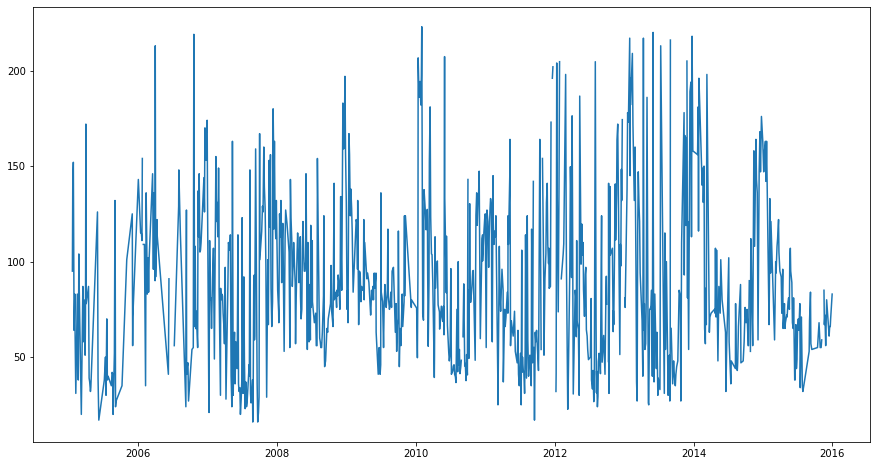

In [12]:
#Index Sorting
df_bbsr_cps = df_bbsr_cps.set_index(df_bbsr_cps['Sampling Date'])
df_bbsr_cps = df_bbsr_cps.sort_index()
# plt.plot(df_bbsr_cps['NO2'])

#Separating Year, Month, Day and Day of Week
df_bbsr_cps['year'] = df_bbsr_cps['Sampling Date'].dt.year 
df_bbsr_cps['month'] = df_bbsr_cps['Sampling Date'].dt.month 
df_bbsr_cps['day'] = df_bbsr_cps['Sampling Date'].dt.day
df_bbsr_cps['day_of_week'] = df_bbsr_cps['Sampling Date'].dt.dayofweek

#Determining Weekend
def weekend(row):
    if (row == 5) or (row == 6):
        return 1
    else:
        return 0

df_bbsr_cps['weekend'] = df_bbsr_cps['day_of_week'].apply(weekend)

#Outlier Removal
mean_cps = df_bbsr_cps['RSPM/PM10'].mean()
std_dev_cps = df_bbsr_cps['RSPM/PM10'].std() #Standard Deviation of NO2

df_bbsr_cps['RSPM/PM10'][df_bbsr_cps['RSPM/PM10'] > (mean_cps + 2.5*std_dev_cps)] = np.nan   #Replacing Outlier with "nan"
plt.plot(df_bbsr_cps['RSPM/PM10'])
df_bbsr_cps.isna().sum()

df_bbsr_cps['RSPM/PM10'] = df_bbsr_cps['RSPM/PM10'].fillna(method = 'backfill')   #Replacing "nan" with the previous values

#Dummy Encoding
df_bbsr_cps = pd.get_dummies( df_bbsr_cps, columns = ['month', 'day_of_week'] )

print("SUCCESS!!")

In [13]:
#Creating Multi-features
xf = df_bbsr_cps[['weekend', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
       'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'RSPM/PM10']]

xf.head()


,weekend,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,RSPM/PM10
Sampling Date,,,,,,,,,,,,,,,,,,,,,
2005-01-14,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,140.0
2005-01-17,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,95.0
2005-01-20,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,95.0
2005-01-22,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,141.0
2005-01-25,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,152.0


In [14]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)


# choose a number of time steps
n_steps_in, n_steps_out = 200, 28

mean_no2 = xf['RSPM/PM10'].mean()
std_no2 = xf['RSPM/PM10'].std()

#Feature Scaling
cols = ['weekend', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
       'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'RSPM/PM10']

for field in cols:
    xf[field] = (xf[field] - xf[field].mean())/xf[field].std()


X, y = split_sequences(xf.values, n_steps_in, n_steps_out)

X_test, y_test = X[-1], y[-1]

for i in range(n_steps_out):
	X = np.delete(X, X.shape[0] - 1, 0)
	y = np.delete(y, y.shape[0] - 1, 0)

n_features = X.shape[2]
                     
print("SUCCESS!!")

SUCCESS!!


In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import LSTM
from keras.layers.normalization import BatchNormalization

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

print('SUCCESS!!')

SUCCESS!!


In [16]:
from tensorflow.keras.callbacks import EarlyStopping

monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=50, verbose=1, mode='auto',
        restore_best_weights=True)
model.fit(X, y, callbacks=[monitor], verbose=2, epochs=2000)

# # fit model
# model.fit(X, y, epochs=2000, verbose=2)

Epoch 1/2000
 - 1s - loss: 1.0023
Epoch 2/2000
 - 0s - loss: 0.9076
Epoch 3/2000
 - 0s - loss: 0.7893
Epoch 4/2000
 - 0s - loss: 0.7022
Epoch 5/2000
 - 0s - loss: 0.6523
Epoch 6/2000
 - 0s - loss: 0.6262
Epoch 7/2000
 - 0s - loss: 0.6047
Epoch 8/2000
 - 0s - loss: 0.5881
Epoch 9/2000
 - 0s - loss: 0.5714
Epoch 10/2000
 - 0s - loss: 0.5588
Epoch 11/2000
 - 0s - loss: 0.5463
Epoch 12/2000
 - 0s - loss: 0.5368
Epoch 13/2000
 - 0s - loss: 0.5296
Epoch 14/2000
 - 0s - loss: 0.5215
Epoch 15/2000
 - 0s - loss: 0.5170
Epoch 16/2000
 - 0s - loss: 0.5110
Epoch 17/2000
 - 0s - loss: 0.5059
Epoch 18/2000
 - 0s - loss: 0.4994
Epoch 19/2000
 - 0s - loss: 0.4963
Epoch 20/2000
 - 0s - loss: 0.4932
Epoch 21/2000
 - 0s - loss: 0.4888
Epoch 22/2000
 - 0s - loss: 0.4858
Epoch 23/2000
 - 0s - loss: 0.4821
Epoch 24/2000
 - 0s - loss: 0.4768
Epoch 25/2000
 - 0s - loss: 0.4744
Epoch 26/2000
 - 0s - loss: 0.4695
Epoch 27/2000
 - 0s - loss: 0.4649
Epoch 28/2000
 - 0s - loss: 0.4630
Epoch 29/2000
 - 0s - loss: 0

In [17]:
x_input = array(X_test)
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=2)
print((yhat[0]*std_no2)+mean_no2)
print((y_test*std_no2)+mean_no2)

[ 77.787025  63.033325  62.16842   67.76045   84.27981   77.56702
  50.776966  57.82017   91.24227   96.05058   70.71343   65.59218
  47.94032   74.53505   70.48195   70.863655  91.42665   99.877686
  99.49036   89.18699   77.25502   83.03433   75.503204  76.43603
  83.639496 103.988556  99.15895  102.57351 ]
[64. 78. 34. 71. 59. 35. 32. 53. 69. 84. 57. 54. 55. 68. 55. 55. 59. 85.
 85. 67. 72. 56. 80. 61. 66. 66. 70. 83.]


In [18]:
y_test = (y_test*std_no2)+mean_no2
yhat = (yhat[0]*std_no2)+mean_no2
print(yhat)
print(y_test)

[ 77.787025  63.033325  62.16842   67.76045   84.27981   77.56702
  50.776966  57.82017   91.24227   96.05058   70.71343   65.59218
  47.94032   74.53505   70.48195   70.863655  91.42665   99.877686
  99.49036   89.18699   77.25502   83.03433   75.503204  76.43603
  83.639496 103.988556  99.15895  102.57351 ]
[64. 78. 34. 71. 59. 35. 32. 53. 69. 84. 57. 54. 55. 68. 55. 55. 59. 85.
 85. 67. 72. 56. 80. 61. 66. 66. 70. 83.]


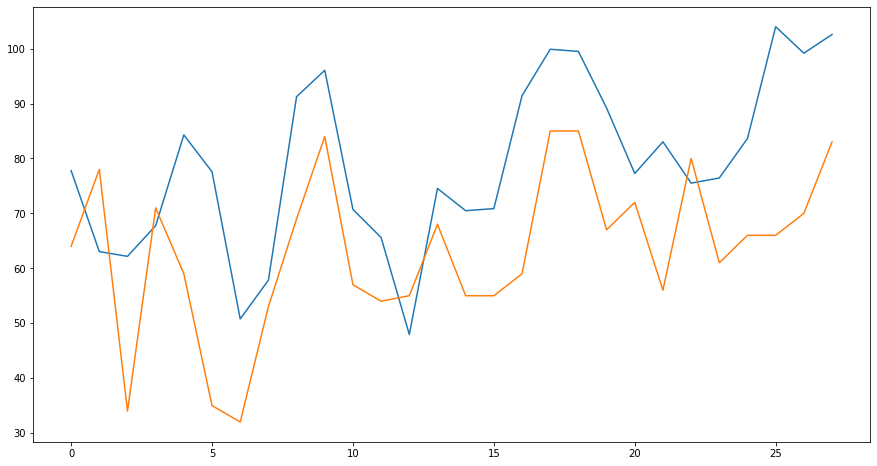

In [19]:
# fig, ax = plt.subplots()
plt.plot(yhat)
plt.plot(y_test)
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
def mean_absolute_percentage_error(y_true, y_pred): 
    # y_true, y_pred = check_arrays(y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


rms = sqrt(mean_squared_error(y_test, yhat))
print(rms)

mse = mean_squared_error(y_test, yhat)
print(mse)

mae = mean_absolute_error(y_test, yhat)
print(mae)

mape = mean_absolute_percentage_error(y_test, yhat)
print(mape)

20.328382482342963
413.2431343484282
17.739599909101212
31.806262763497234
